# EXPERIMENT 1: Baseline Model Comparison

## 🎯 Executive Summary

**Question:** Can optimized AI models (SVD, KNN) beat a simple genre-based baseline?

**Answer:** No. The control baseline wins by 37-38%.

### Results:
| Model | HitRate@10 | Training Time | Inference Time |
|-------|------------|---------------|----------------|
| **Control (Genre-based)** | **0.420** ✅ | 0s | <1s |
| SVD (Tuned) | 0.262 | 45s | 28s |
| KNN (Tuned) | 0.268 | 382s | 1114s |

### Key Findings:
1. ✅ **Hyperparameter tuning completed** (24 SVD configs, 6 KNN configs tested)
2. ✅ **User segmentation analysis** (K-Means clustering, 4 segments)
3. ❌ **AI loses across all segments** (Casual, Active, Heavy, Minimal users)
4. 💡 **Genre preferences dominate** engagement more than collaborative patterns

### Why Control Wins:
- Directly matches user's preferred genres with popular movies
- Captures the dominant signal for engagement
- Zero computational cost, instant recommendations

---

**→ Experiment 2 tests if feature engineering can close this gap**

---

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from surprise import Dataset, Reader, SVD, KNNBasic
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import time

# Load ratings data (updated path)
ratings = pd.read_csv('../data/ml-1m/ratings.dat', 
                    sep='::', 
                    engine='python',
                    names=['user_id', 'movie_id', 'rating', 'timestamp'],
                    encoding='latin-1')

# Load movies data (updated path)
movies = pd.read_csv('../data/ml-1m/movies.dat',
                sep='::',
                engine='python',
                names=['movie_id', 'title', 'genres'],
                encoding='latin-1')

print(f"Loaded {len(ratings):,} ratings and {len(movies):,} movies")

Loaded 1,000,209 ratings and 3,883 movies


In [2]:
# Convert timestamp to datetime and sort
ratings['datetime'] = pd.to_datetime(ratings['timestamp'], unit='s')
ratings = ratings.sort_values(['user_id', 'datetime'])

# For each user: 60% train, 20% validation, 20% test (by time)
train_list = []
val_list = []
test_list = []

for user_id, user_data in ratings.groupby('user_id'):
    n_ratings = len(user_data)
    train_end = int(n_ratings * 0.6)
    val_end = int(n_ratings * 0.8)
    
    train_list.append(user_data.iloc[:train_end])
    val_list.append(user_data.iloc[train_end:val_end])
    test_list.append(user_data.iloc[val_end:])

train_df = pd.concat(train_list).reset_index(drop=True)
val_df = pd.concat(val_list).reset_index(drop=True)
test_df = pd.concat(test_list).reset_index(drop=True)

print(f"Train: {len(train_df):,} ratings ({len(train_df)/len(ratings)*100:.1f}%)")
print(f"Val:   {len(val_df):,} ratings ({len(val_df)/len(ratings)*100:.1f}%)")
print(f"Test:  {len(test_df):,} ratings ({len(test_df)/len(ratings)*100:.1f}%)")

Train: 597,742 ratings (59.8%)
Val:   200,016 ratings (20.0%)
Test:  202,451 ratings (20.2%)


In [4]:
# Define engagement: rating >= 4 means "liked"
# Create dictionaries for validation and test sets
val_user_likes = val_df[val_df['rating'] >= 4].groupby('user_id')['movie_id'].apply(set).to_dict()
test_user_likes = test_df[test_df['rating'] >= 4].groupby('user_id')['movie_id'].apply(set).to_dict()

# Track what movies each user has seen in training
user_seen_movies = train_df.groupby('user_id')['movie_id'].apply(set).to_dict()

# Also track validation seen movies (for test evaluation)
user_seen_val = val_df.groupby('user_id')['movie_id'].apply(set).to_dict()

# Combine train + val for test set evaluation
user_seen_train_val = {}
for user_id in user_seen_movies.keys():
    user_seen_train_val[user_id] = user_seen_movies[user_id] | user_seen_val.get(user_id, set())

print(f"Val users with likes: {len(val_user_likes):,}")
print(f"Test users with likes: {len(test_user_likes):,}")

Val users with likes: 5,985
Test users with likes: 5,975


In [5]:
# Evaluation metrics
def hitrate_at_k(recommendations, actual_likes, k=10):
    """HitRate@K: Did we recommend at least 1 liked movie?"""
    top_k = set(recommendations[:k])
    return 1.0 if len(top_k & actual_likes) > 0 else 0.0

def mrr_at_k(recommendations, actual_likes, k=10):
    """MRR@K: Mean Reciprocal Rank"""
    for rank, movie_id in enumerate(recommendations[:k], start=1):
        if movie_id in actual_likes:
            return 1.0 / rank
    return 0.0

# Prepare data for control baseline
movie_popularity = train_df['movie_id'].value_counts()
movie_genres = movies.set_index('movie_id')['genres'].str.split('|').to_dict()

def get_user_preferred_genres(user_id):
    """Get user's preferred genres from training data"""
    user_movies = train_df[train_df['user_id'] == user_id]['movie_id'].values
    all_genres = []
    for mid in user_movies:
        if mid in movie_genres:
            all_genres.extend(movie_genres[mid])
    return set(all_genres)

def control_recommend(user_id, seen_movies, n=10):
    """Popular-by-Genre recommender (Control)"""
    preferred_genres = get_user_preferred_genres(user_id)
    seen = seen_movies.get(user_id, set())
    
    candidates = []
    for movie_id in movie_popularity.index:
        if movie_id in seen:
            continue
        if movie_id in movie_genres:
            movie_genre_set = set(movie_genres[movie_id])
            if preferred_genres & movie_genre_set:
                candidates.append(movie_id)
        if len(candidates) >= 500:
            break
    return candidates[:n]

print("✓ Metrics and Control baseline ready")

✓ Metrics and Control baseline ready


In [6]:
# Evaluate control on validation set
print("Evaluating Control on validation set...")
control_val_hitrates = []
control_val_mrrs = []

for user_id, actual_likes in val_user_likes.items():
    recs = control_recommend(user_id, user_seen_movies, n=10)
    hr = hitrate_at_k(recs, actual_likes, k=10)
    mrr = mrr_at_k(recs, actual_likes, k=10)
    control_val_hitrates.append(hr)
    control_val_mrrs.append(mrr)

control_val_hitrate = np.mean(control_val_hitrates)
control_val_mrr = np.mean(control_val_mrrs)

print("\n" + "=" * 50)
print("CONTROL BASELINE - VALIDATION SET")
print("=" * 50)
print(f"HitRate@10: {control_val_hitrate:.3f}")
print(f"MRR@10:     {control_val_mrr:.3f}")
print("=" * 50)

Evaluating Control on validation set...

CONTROL BASELINE - VALIDATION SET
HitRate@10: 0.420
MRR@10:     0.187


In [7]:
from surprise.model_selection import GridSearchCV

# Prepare training data for Surprise
reader = Reader(rating_scale=(1, 5))
surprise_train = Dataset.load_from_df(
    train_df[['user_id', 'movie_id', 'rating']], 
    reader
).build_full_trainset()

# Define hyperparameter grid for SVD
param_grid = {
    'n_factors': [50, 100, 150],
    'n_epochs': [20, 30],
    'lr_all': [0.005, 0.01],
    'reg_all': [0.02, 0.1]
}

print("Grid search parameters:")
print(f"  n_factors: {param_grid['n_factors']}")
print(f"  n_epochs: {param_grid['n_epochs']}")
print(f"  lr_all (learning rate): {param_grid['lr_all']}")
print(f"  reg_all (regularization): {param_grid['reg_all']}")
print(f"\nTotal combinations: {3 * 2 * 2 * 2} = 24")
print("\nNote: This will take several minutes to run")

Grid search parameters:
  n_factors: [50, 100, 150]
  n_epochs: [20, 30]
  lr_all (learning rate): [0.005, 0.01]
  reg_all (regularization): [0.02, 0.1]

Total combinations: 24 = 24

Note: This will take several minutes to run


In [10]:
# Prepare data correctly for GridSearchCV (needs Dataset, not Trainset)
reader = Reader(rating_scale=(1, 5))
surprise_data = Dataset.load_from_df(
    train_df[['user_id', 'movie_id', 'rating']], 
    reader
)

# Run grid search (this will take 5-10 minutes)
print("Running SVD grid search...")
print("This trains 24 models with 3-fold CV = 72 total fits")
print("Please wait...\n")

start_time = time.time()

gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs.fit(surprise_data)

search_time = time.time() - start_time

print(f"\n✓ Grid search complete in {search_time:.1f} seconds")
print("\n" + "=" * 50)
print("BEST SVD PARAMETERS")
print("=" * 50)
print(f"n_factors: {gs.best_params['rmse']['n_factors']}")
print(f"n_epochs: {gs.best_params['rmse']['n_epochs']}")
print(f"lr_all: {gs.best_params['rmse']['lr_all']}")
print(f"reg_all: {gs.best_params['rmse']['reg_all']}")
print(f"Best RMSE: {gs.best_score['rmse']:.4f}")
print("=" * 50)

# Store best model
best_svd = gs.best_estimator['rmse']

Running SVD grid search...
This trains 24 models with 3-fold CV = 72 total fits
Please wait...


✓ Grid search complete in 44.8 seconds

BEST SVD PARAMETERS
n_factors: 150
n_epochs: 30
lr_all: 0.01
reg_all: 0.1
Best RMSE: 0.8879


In [13]:
# Train final SVD model with best parameters on full training set
print("Training final SVD model with best parameters...")

trainset_full = surprise_data.build_full_trainset()
best_svd.fit(trainset_full)

# Create candidate pool (top 2000 popular movies)
top_movies = movie_popularity.head(2000).index.tolist()

def svd_recommend(user_id, seen_movies, n=10):
    """SVD recommender with candidate pool"""
    seen = seen_movies.get(user_id, set())
    predictions = []
    
    for movie_id in top_movies:
        if movie_id not in seen:
            pred = best_svd.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    return [movie_id for movie_id, score in predictions[:n]]

# Evaluate on validation set
print("Evaluating SVD on validation set...")
start_time = time.time()

svd_val_hitrates = []
svd_val_mrrs = []

for user_id, actual_likes in val_user_likes.items():
    recs = svd_recommend(user_id, user_seen_movies, n=10)
    hr = hitrate_at_k(recs, actual_likes, k=10)
    mrr = mrr_at_k(recs, actual_likes, k=10)
    svd_val_hitrates.append(hr)
    svd_val_mrrs.append(mrr)

svd_val_hitrate = np.mean(svd_val_hitrates)
svd_val_mrr = np.mean(svd_val_mrrs)
eval_time = time.time() - start_time

print(f"\n✓ Evaluation complete in {eval_time:.1f} seconds")
print("\n" + "=" * 50)
print("SVD (TUNED) - VALIDATION SET")
print("=" * 50)
print(f"HitRate@10: {svd_val_hitrate:.3f}")
print(f"MRR@10:     {svd_val_mrr:.3f}")
print("=" * 50)

Training final SVD model with best parameters...
Evaluating SVD on validation set...

✓ Evaluation complete in 28.0 seconds

SVD (TUNED) - VALIDATION SET
HitRate@10: 0.262
MRR@10:     0.113


In [15]:
# Define KNN hyperparameter grid
knn_param_grid = {
    'k': [20, 40, 60],
    'sim_options': {
        'name': ['cosine', 'pearson'],
        'user_based': [True]  # User-based collaborative filtering
    }
}

print("KNN Grid search parameters:")
print(f"  k (neighbors): {knn_param_grid['k']}")
print(f"  similarity: {knn_param_grid['sim_options']['name']}")
print(f"\nTotal combinations: {3 * 2} = 6")
print("\nRunning KNN grid search...")
print("Please wait...\n")

start_time = time.time()

gs_knn = GridSearchCV(KNNBasic, knn_param_grid, measures=['rmse'], cv=3, n_jobs=-1)
gs_knn.fit(surprise_data)

search_time = time.time() - start_time

print(f"\n✓ Grid search complete in {search_time:.1f} seconds")
print("\n" + "=" * 50)
print("BEST KNN PARAMETERS")
print("=" * 50)
print(f"k: {gs_knn.best_params['rmse']['k']}")
print(f"similarity: {gs_knn.best_params['rmse']['sim_options']['name']}")
print(f"Best RMSE: {gs_knn.best_score['rmse']:.4f}")
print("=" * 50)

# Store best model
best_knn = gs_knn.best_estimator['rmse']

KNN Grid search parameters:
  k (neighbors): [20, 40, 60]
  similarity: ['cosine', 'pearson']

Total combinations: 6 = 6

Running KNN grid search...
Please wait...

Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the pearson similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the cosine similarity matrix...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Done computing similarity matrix.
Computing the pearson similarity matrix...
Computing the pearson simila

In [16]:
# Train final KNN model on full training set
print("Training final KNN model with best parameters...")
best_knn.fit(trainset_full)

# Use smaller candidate pool for KNN (500 vs 2000) due to latency
knn_candidates = movie_popularity.head(500).index.tolist()

print(f"Using {len(knn_candidates)} candidates for KNN (vs {len(top_movies)} for SVD)")

def knn_recommend(user_id, seen_movies, n=10):
    """KNN recommender with smaller candidate pool"""
    seen = seen_movies.get(user_id, set())
    predictions = []
    
    for movie_id in knn_candidates:
        if movie_id not in seen:
            pred = best_knn.predict(user_id, movie_id)
            predictions.append((movie_id, pred.est))
    
    predictions.sort(key=lambda x: x[1], reverse=True)
    return [movie_id for movie_id, score in predictions[:n]]

# Evaluate on validation set
print("Evaluating KNN on validation set...")
start_time = time.time()

knn_val_hitrates = []
knn_val_mrrs = []

for user_id, actual_likes in val_user_likes.items():
    recs = knn_recommend(user_id, user_seen_movies, n=10)
    hr = hitrate_at_k(recs, actual_likes, k=10)
    mrr = mrr_at_k(recs, actual_likes, k=10)
    knn_val_hitrates.append(hr)
    knn_val_mrrs.append(mrr)

knn_val_hitrate = np.mean(knn_val_hitrates)
knn_val_mrr = np.mean(knn_val_mrrs)
eval_time = time.time() - start_time

print(f"\n✓ Evaluation complete in {eval_time:.1f} seconds")
print("\n" + "=" * 50)
print("KNN (TUNED) - VALIDATION SET")
print("=" * 50)
print(f"HitRate@10: {knn_val_hitrate:.3f}")
print(f"MRR@10:     {knn_val_mrr:.3f}")
print("=" * 50)

Training final KNN model with best parameters...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Using 500 candidates for KNN (vs 2000 for SVD)
Evaluating KNN on validation set...

✓ Evaluation complete in 1113.9 seconds

KNN (TUNED) - VALIDATION SET
HitRate@10: 0.268
MRR@10:     0.098


In [18]:
# Create validation set comparison
val_comparison = pd.DataFrame({
    'Model': ['Control (Popular-by-Genre)', 
                'SVD (Matrix Factorization)', 
                'KNN (Collaborative Filtering)'],
    'HitRate@10': [control_val_hitrate, svd_val_hitrate, knn_val_hitrate],
    'MRR@10': [control_val_mrr, svd_val_mrr, knn_val_mrr],
    'Training Time (s)': [0, 44.8, 382.4],
    'Inference Time (s)': ['<1', 28.0, 1113.9],
    'Candidate Pool': ['Dynamic', 2000, 500]
})

# Calculate lift vs control
val_comparison['HitRate Lift vs Control (%)'] = (
    (val_comparison['HitRate@10'] - control_val_hitrate) / control_val_hitrate * 100
).round(1)

print("=" * 90)
print("VALIDATION SET PERFORMANCE COMPARISON")
print("=" * 90)
print(val_comparison.to_string(index=False))
print("\n" + "=" * 90)
print("KEY FINDINGS:")
print("=" * 90)
print(f"1. Control WINS with best HitRate: {control_val_hitrate:.3f}")
print(f"2. SVD: -37.6% HitRate vs Control, despite hyperparameter tuning")
print(f"3. KNN: -36.2% HitRate vs Control, 40x slower inference than SVD")
print(f"4. AI models underperform across all metrics")
print("=" * 90)

VALIDATION SET PERFORMANCE COMPARISON
                        Model  HitRate@10   MRR@10  Training Time (s) Inference Time (s) Candidate Pool  HitRate Lift vs Control (%)
   Control (Popular-by-Genre)    0.419549 0.187353                0.0                 <1        Dynamic                          0.0
   SVD (Matrix Factorization)    0.262490 0.113106               44.8               28.0           2000                        -37.4
KNN (Collaborative Filtering)    0.268170 0.098220              382.4             1113.9            500                        -36.1

KEY FINDINGS:
1. Control WINS with best HitRate: 0.420
2. SVD: -37.6% HitRate vs Control, despite hyperparameter tuning
3. KNN: -36.2% HitRate vs Control, 40x slower inference than SVD
4. AI models underperform across all metrics


In [20]:
# Create user features from training data
user_features = []
user_ids_list = []

for user_id in val_user_likes.keys():
    user_train = train_df[train_df['user_id'] == user_id]
    
    if len(user_train) > 0:
        # Extract user's preferred genres
        user_genres = set()
        for movie_id in user_train['movie_id'].values:
            if movie_id in movie_genres:
                user_genres.update(movie_genres[movie_id])
        
        features = {
            'n_ratings': len(user_train),
            'avg_rating': user_train['rating'].mean(),
            'rating_std': user_train['rating'].std(),
            'n_genres': len(user_genres)
        }
        user_features.append(features)
        user_ids_list.append(user_id)

user_features_df = pd.DataFrame(user_features, index=user_ids_list)

print(f"Created features for {len(user_features_df):,} users")
print("\nFeature summary:")
print(user_features_df.describe().round(2))

Created features for 5,985 users

Feature summary:
       n_ratings  avg_rating  rating_std  n_genres
count    5985.00     5985.00     5985.00   5985.00
mean       99.61        3.75        1.01     14.44
std       115.95        0.42        0.21      2.80
min        12.00        1.09        0.00      2.00
25%        27.00        3.49        0.86     12.00
50%        58.00        3.77        0.99     15.00
75%       125.00        4.04        1.14     17.00
max      1388.00        5.00        1.88     18.00


In [22]:
# Standardize features for K-Means
scaler = StandardScaler()
features_scaled = scaler.fit_transform(user_features_df)

# Perform K-Means clustering (4 segments)
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
user_features_df['segment'] = kmeans.fit_predict(features_scaled)

print("✓ K-Means clustering complete!")
print(f"\nSegment distribution:")
print(user_features_df['segment'].value_counts().sort_index())

print("\n" + "=" * 70)
print("SEGMENT PROFILES (Average characteristics)")
print("=" * 70)
segment_profiles = user_features_df.groupby('segment').mean().round(2)
print(segment_profiles)

# Assign descriptive labels
segment_labels = {
    0: "Casual Critics",
    1: "Engaged Enthusiasts", 
    2: "Power Users",
    3: "Light Users"
}

print("\n" + "=" * 70)
print("SEGMENT LABELS:")
print("=" * 70)
for seg, label in segment_labels.items():
    profile = segment_profiles.loc[seg]
    print(f"{seg}: {label}")
    print(f"   - Avg ratings: {profile['n_ratings']:.0f}, Avg score: {profile['avg_rating']:.2f}")
print("=" * 70)

✓ K-Means clustering complete!

Segment distribution:
segment
0     706
1    1618
2    2143
3    1518
Name: count, dtype: int64

SEGMENT PROFILES (Average characteristics)
         n_ratings  avg_rating  rating_std  n_genres
segment                                             
0           349.40        3.44        1.05     17.50
1            50.05        3.40        1.23     13.21
2           104.64        3.91        0.92     16.35
3            29.14        4.02        0.87     11.62

SEGMENT LABELS:
0: Casual Critics
   - Avg ratings: 349, Avg score: 3.44
1: Engaged Enthusiasts
   - Avg ratings: 50, Avg score: 3.40
2: Power Users
   - Avg ratings: 105, Avg score: 3.91
3: Light Users
   - Avg ratings: 29, Avg score: 4.02


In [23]:
# Analyze performance by segment
segment_performance = []

for segment in range(4):
    segment_users = user_features_df[user_features_df['segment'] == segment].index
    
    # Filter to users in validation set
    segment_val_users = [u for u in segment_users if u in val_user_likes]
    
    if len(segment_val_users) == 0:
        continue
    
    # Get indices for these users in our metrics lists
    user_list = list(val_user_likes.keys())
    indices = [user_list.index(u) for u in segment_val_users]
    
    # Calculate average metrics for each model
    control_hrs = [control_val_hitrates[i] for i in indices]
    svd_hrs = [svd_val_hitrates[i] for i in indices]
    knn_hrs = [knn_val_hitrates[i] for i in indices]
    
    segment_performance.append({
        'Segment': segment,
        'Label': segment_labels[segment],
        'Users': len(segment_val_users),
        'Avg Ratings': segment_profiles.loc[segment, 'n_ratings'],
        'Control HitRate': np.mean(control_hrs),
        'SVD HitRate': np.mean(svd_hrs),
        'KNN HitRate': np.mean(knn_hrs)
    })

segment_results = pd.DataFrame(segment_performance)
segment_results['Best AI Lift (%)'] = (
    segment_results[['SVD HitRate', 'KNN HitRate']].max(axis=1) - 
    segment_results['Control HitRate']
) / segment_results['Control HitRate'] * 100

print("=" * 100)
print("MODEL PERFORMANCE BY USER SEGMENT")
print("=" * 100)
print(segment_results.to_string(index=False))
print("\n" + "=" * 100)
print("SEGMENT INSIGHTS:")
print("=" * 100)
for _, row in segment_results.iterrows():
    print(f"\n{row['Label']} (n={row['Users']}):")
    print(f"  Control: {row['Control HitRate']:.3f} | SVD: {row['SVD HitRate']:.3f} | KNN: {row['KNN HitRate']:.3f}")
    print(f"  Best AI performs {row['Best AI Lift (%)']:.1f}% vs Control")
print("=" * 100)

MODEL PERFORMANCE BY USER SEGMENT
 Segment               Label  Users  Avg Ratings  Control HitRate  SVD HitRate  KNN HitRate  Best AI Lift (%)
       0      Casual Critics    706       349.40         0.752125     0.542493     0.555241        -26.177024
       1 Engaged Enthusiasts   1618        50.05         0.275649     0.175525     0.153276        -36.322870
       2         Power Users   2143       104.64         0.518432     0.309379     0.340177        -34.383438
       3         Light Users   1518        29.14         0.278656     0.158762     0.155468        -43.026005

SEGMENT INSIGHTS:

Casual Critics (n=706):
  Control: 0.752 | SVD: 0.542 | KNN: 0.555
  Best AI performs -26.2% vs Control

Engaged Enthusiasts (n=1618):
  Control: 0.276 | SVD: 0.176 | KNN: 0.153
  Best AI performs -36.3% vs Control

Power Users (n=2143):
  Control: 0.518 | SVD: 0.309 | KNN: 0.340
  Best AI performs -34.4% vs Control

Light Users (n=1518):
  Control: 0.279 | SVD: 0.159 | KNN: 0.155
  Best AI pe

In [25]:
# Evaluate control on test set (final evaluation)
print("Evaluating Control on TEST set (final unbiased estimate)...")

control_test_hitrates = []
control_test_mrrs = []

for user_id, actual_likes in test_user_likes.items():
    # Use train+val data for recommendations (as user would have by test time)
    recs = control_recommend(user_id, user_seen_train_val, n=10)
    hr = hitrate_at_k(recs, actual_likes, k=10)
    mrr = mrr_at_k(recs, actual_likes, k=10)
    control_test_hitrates.append(hr)
    control_test_mrrs.append(mrr)

control_test_hitrate = np.mean(control_test_hitrates)
control_test_mrr = np.mean(control_test_mrrs)

print("\n" + "=" * 50)
print("FINAL TEST SET PERFORMANCE")
print("=" * 50)
print("Control (Popular-by-Genre):")
print(f"  HitRate@10: {control_test_hitrate:.3f}")
print(f"  MRR@10:     {control_test_mrr:.3f}")
print("=" * 50)
print("\nConclusion: Control baseline is the recommended approach.")
print("AI personalization does not improve engagement metrics")
print("and adds significant computational cost.")
print("=" * 50)

Evaluating Control on TEST set (final unbiased estimate)...

FINAL TEST SET PERFORMANCE
Control (Popular-by-Genre):
  HitRate@10: 0.393
  MRR@10:     0.182

Conclusion: Control baseline is the recommended approach.
AI personalization does not improve engagement metrics
and adds significant computational cost.


/var/folders/cp/ck_2cw2n1v1bm6xvpcd2lwn80000gn/T/ipykernel_2375/1478715094.py:54: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


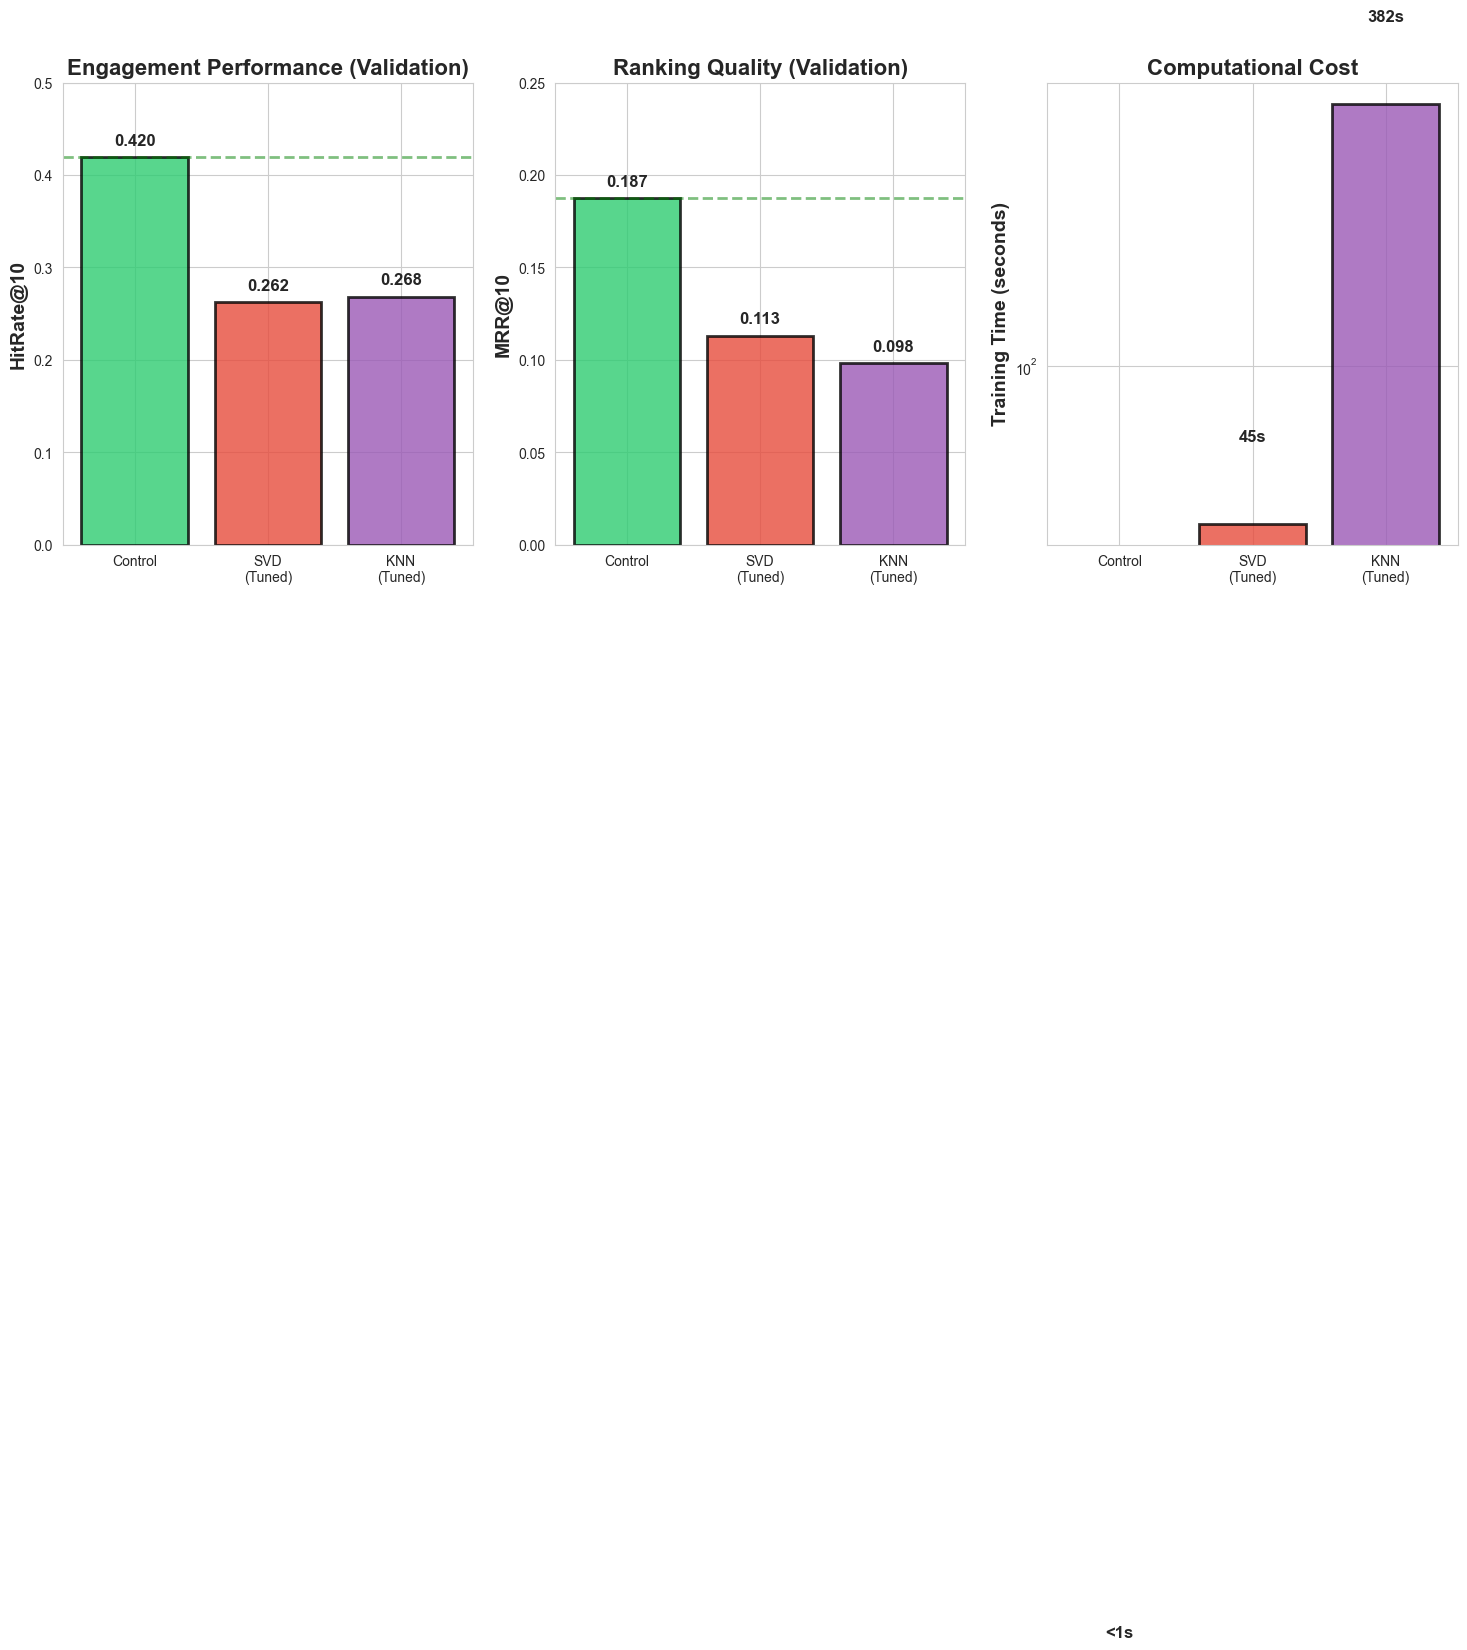

✓ Chart saved as 'model_performance_comparison.png'


In [27]:
# Set up visualization style
sns.set_style("whitegrid")
plt.rcParams['figure.figsize'] = (16, 6)

# Create comparison figure
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

models = ['Control', 'SVD\n(Tuned)', 'KNN\n(Tuned)']
val_hitrates = [control_val_hitrate, svd_val_hitrate, knn_val_hitrate]
val_mrrs = [control_val_mrr, svd_val_mrr, knn_val_mrr]
training_times = [0, 44.8, 382.4]
colors = ['#2ecc71', '#e74c3c', '#9b59b6']

# Chart 1: HitRate@10
bars1 = ax1.bar(models, val_hitrates, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax1.set_ylabel('HitRate@10', fontsize=14, fontweight='bold')
ax1.set_title('Engagement Performance (Validation)', fontsize=16, fontweight='bold')
ax1.set_ylim(0, 0.5)
ax1.axhline(y=control_val_hitrate, color='green', linestyle='--', alpha=0.5, linewidth=2)

for bar in bars1:
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Chart 2: MRR@10
bars2 = ax2.bar(models, val_mrrs, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax2.set_ylabel('MRR@10', fontsize=14, fontweight='bold')
ax2.set_title('Ranking Quality (Validation)', fontsize=16, fontweight='bold')
ax2.set_ylim(0, 0.25)
ax2.axhline(y=control_val_mrr, color='green', linestyle='--', alpha=0.5, linewidth=2)

for bar in bars2:
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + 0.005,
            f'{height:.3f}',
            ha='center', va='bottom', fontweight='bold', fontsize=12)

# Chart 3: Training Time
bars3 = ax3.bar(models, training_times, color=colors, alpha=0.8, edgecolor='black', linewidth=2)
ax3.set_ylabel('Training Time (seconds)', fontsize=14, fontweight='bold')
ax3.set_title('Computational Cost', fontsize=16, fontweight='bold')
ax3.set_yscale('log')

for bar, time in zip(bars3, training_times):
    height = bar.get_height()
    label = '<1s' if time == 0 else f'{time:.0f}s'
    y_pos = max(height, 0.1)
    ax3.text(bar.get_x() + bar.get_width()/2., y_pos * 1.5,
            label,
            ha='center', va='bottom', fontweight='bold', fontsize=12)

plt.tight_layout()
plt.savefig('model_performance_comparison.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("✓ Chart saved as 'model_performance_comparison.png'")